In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy

import gensim
import pyLDAvis.gensim

from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data= pd.read_csv('..\\Data\\train_data\\train.csv')
data.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [3]:
data.dtypes

id                     int64
text                  object
is_humor               int64
humor_rating         float64
humor_controversy    float64
offense_rating       float64
dtype: object

In [4]:
data.count()

id                   8000
text                 8000
is_humor             8000
humor_rating         4932
humor_controversy    4932
offense_rating       8000
dtype: int64

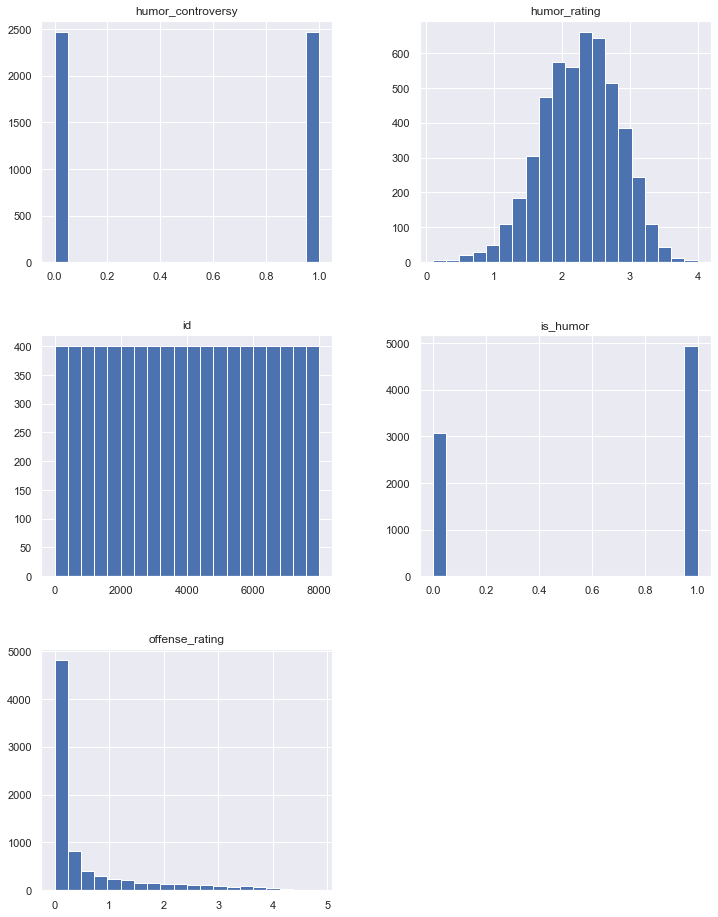

In [5]:
data.hist(bins = 20,figsize= (12,16));

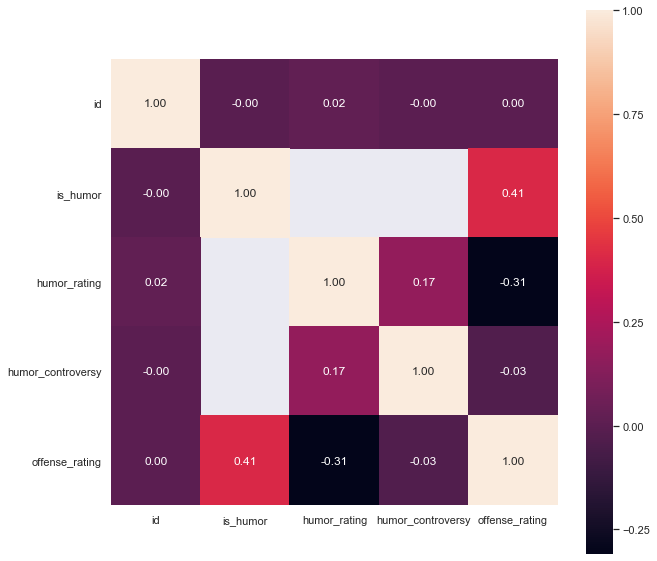

In [6]:
corr = data.corr()
plt.figure(figsize = (10,10))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f')
plt.show();

# Text Statistics

## Charaters in each sentence

### All sentences

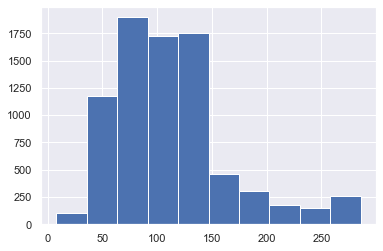

In [7]:
data['text'].str.len().hist()

### Sentences tagged humorous by all

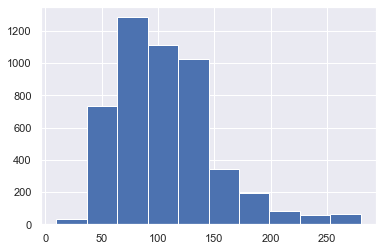

In [8]:
humor = data['is_humor']==1    
humor = data[humor]
humor['text'].str.len().hist()

### Sentences tagged not humorous

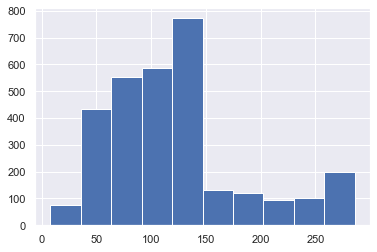

In [9]:
not_humor = data['is_humor']==0    
not_humor_df = data[not_humor]
not_humor_df['text'].str.len().hist()

## Words in each sentence

### All sentences

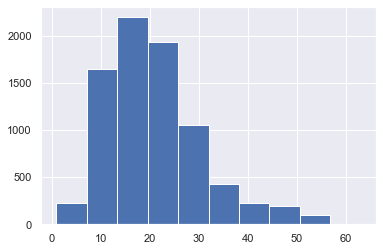

In [10]:
data['text'].str.split().map(lambda x: len(x)).hist()

### Sentences tagged humorous by all

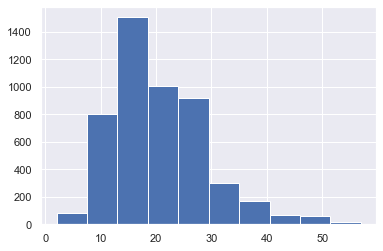

In [11]:
humor['text'].str.split().map(lambda x: len(x)).hist()

### Sentences tagged not humorous

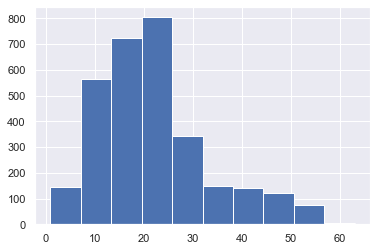

In [12]:
not_humor_df['text'].str.split().map(lambda x: len(x)).hist()

## Average word length in each sentence

### All Sentences

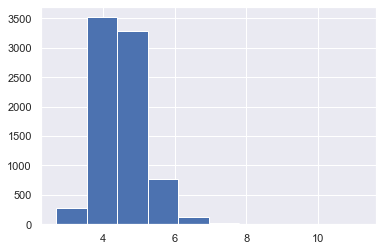

In [13]:
data['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### Sentences tagged humorous by all

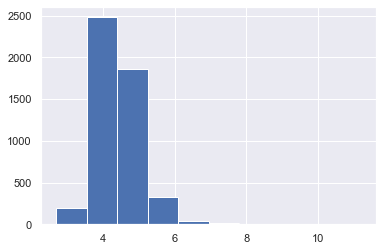

In [14]:
humor['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### Sentences tagged not humorous

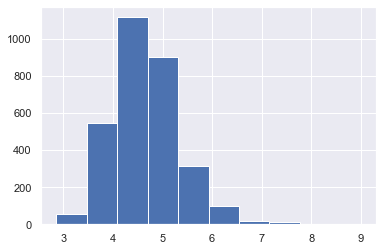

In [15]:
not_humor_df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

## Stopwords frequency

In [16]:
stop = set(stopwords.words('english'))

In [17]:
corpus = []
text = data['text'].str.split()
text = text.values.tolist()
corpus=[word for i in text for word in i]
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<BarContainer object of 15 artists>

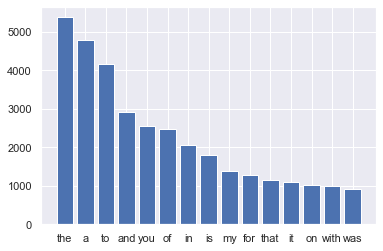

In [18]:
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y = zip(*top)
plt.bar(x,y)

## Most frequent words that are not stopwords

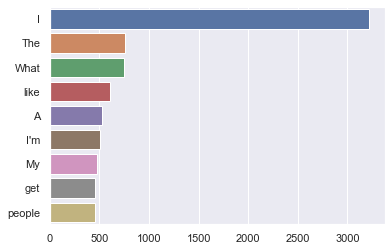

In [19]:
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

## ngrams

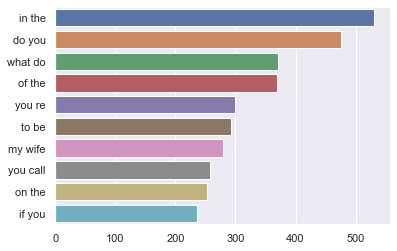

In [20]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]
top_n_bigrams = get_top_ngram(data['text'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)


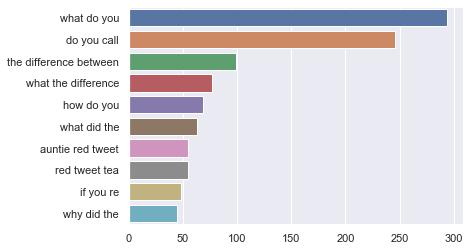

In [21]:
top_tri_grams=get_top_ngram(data['text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

## Topic Modeling using LDA

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\keerr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
def preprocess_data(df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for d in df['text']:
        words = [w for w in word_tokenize(d) if (w not in stop)]
        
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus
corpus = preprocess_data(data)

In [24]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [25]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.019*"n\'t" + 0.014*"What" + 0.013*"people" + 0.011*"..." + 0.008*"Why" + 0.007*"\'ve" + 0.006*"The" + 0.006*"gay" + 0.006*"time" + 0.005*"like"'),
 (1,
  '0.012*"What" + 0.008*"The" + 0.006*"black" + 0.005*"one" + 0.005*"like" + 0.005*"get" + 0.004*"year" + 0.004*"n\'t" + 0.004*"wife" + 0.003*"way"'),
 (2,
  '0.009*"..." + 0.008*"What" + 0.008*"know" + 0.007*"get" + 0.006*"like" + 0.005*"life" + 0.005*"work" + 0.005*"people" + 0.004*"today" + 0.004*"The"'),
 (3,
  '0.020*"n\'t" + 0.010*"What" + 0.009*"get" + 0.008*"girl" + 0.006*"one" + 0.006*"..." + 0.006*"\'re" + 0.006*"woman" + 0.006*"call" + 0.006*"day"'),
 (4,
  '0.018*"n\'t" + 0.009*"Why" + 0.008*"The" + 0.007*"say" + 0.007*"How" + 0.007*"\'re" + 0.006*"What" + 0.005*"like" + 0.005*"wife" + 0.005*"They"'),
 (5,
  '0.012*"The" + 0.010*"What" + 0.009*"one" + 0.007*"..." + 0.006*"health" + 0.005*"people" + 0.005*"year" + 0.005*"mental" + 0.005*"life" + 0.005*"time"'),
 (6,
  '0.011*"What" + 0.009*"like" + 0.007*"call" + 0.

In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

C:\Users\keerr\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.077835  0.000348       1        1  15.638380
0     -0.055774  0.021100       2        1  12.308973
8     -0.025796  0.038539       3        1  10.647176
3     -0.036955  0.027808       4        1  10.296953
4     -0.051895  0.050166       5        1   9.796761
5      0.130704  0.061210       6        1   9.179125
1      0.029237 -0.001383       7        1   8.607484
2      0.022301 -0.033572       8        1   8.200519
9      0.062215 -0.012980       9        1   8.006677
6      0.003799 -0.151235      10        1   7.317948, topic_info=     Category         Freq     Term        Total  loglift  logprob
124   Default  1207.000000      n't  1207.000000  30.0000  30.0000
525   Default   275.000000      Why   275.000000  29.0000  29.0000
2     Default   662.000000      ...   662.000000  28.0000  28.0000
660   Default    56.000000      Red    56.000000  27.0000  27.0000
659   Default    51.000000   Auntie    51.000000  26.0000  26.0000
661   Default    54.000000      Tea    54.000000  25.0000  25.0000
375   Default   150.000000     told   150.000000  24.0000  24.0000
280   Default   322.000000     said   322.000000  23.0000  23.0000
662   Default    55.000000    Tweet    55.000000  22.0000  22.0000
151   Default   814.000000     What   814.000000  21.0000  21.0000
629   Default   323.000000     know   323.000000  20.0000  20.0000
281   Default   352.000000     wife   352.000000  19.0000  19.0000
248   Default   159.000000      gay   159.000000  18.0000  18.0000
184   Default   106.000000   health   106.000000  17.0000  17.0000
34    Default   221.000000      How   221.000000  16.0000  16.0000
156   Default   236.000000      've   236.000000  15.0000  15.0000
521   Default   139.000000  Because   139.000000  14.0000  14.0000
45    Default   175.000000      She   175.000000  13.0000  13.0000
696   Default    57.000000   mental    57.000000  12.0000  12.0000
271   Default    78.000000   doctor    78.000000  11.0000  11.0000
803   Default   110.000000    Black   110.000000  10.0000  10.0000
141   Default   454.000000   people   454.000000   9.0000   9.0000
474   Default   301.000000     call   301.000000   8.0000   8.0000
23    Default   265.000000      day   265.000000   7.0000   7.0000
15    Default   679.000000      The   679.000000   6.0000   6.0000
363   Default   220.000000     girl   220.000000   5.0000   5.0000
100   Default   392.000000      one   392.000000   4.0000   4.0000
137   Default   224.000000     life   224.000000   3.0000   3.0000
153   Default   442.000000      get   442.000000   2.0000   2.0000
183   Default    83.000000     food    83.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
684   Topic10    19.122421  believe    70.921364   1.3041  -5.8750
3508  Topic10     8.672015    pizza    20.782104   1.7408  -6.6658
151   Topic10    77.667023     What   814.251343   0.2650  -4.4734
59    Topic10    11.106803     Love    32.320389   1.5467  -6.4183
238   Topic10    59.826401     like   563.410889   0.3723  -4.7344
814   Topic10    22.398378    There   111.451897   1.0102  -5.7169
43    Topic10    39.015034     time   321.961212   0.5044  -5.1619
465   Topic10    32.626255    would   247.213440   0.5897  -5.3407
0     Topic10    40.354790      're   401.772552   0.3167  -5.1281
1125  Topic10    11.229777   chance    34.559753   1.4907  -6.4073
1133  Topic10    19.909174     keep   109.044724   0.9143  -5.8347
948   Topic10    15.487177      Did    67.437408   1.1437  -6.0858
253   Topic10    19.321468      But   110.103592   0.8746  -5.8646
153   Topic10    37.056309      get   442.914459   0.1339  -5.2134
27    Topic10    26.079557      man   224.345596   0.4628  -5.5647
693   Topic10    23.716084     good   187.641541   0.5465  -5.6597
2     Topic10    39.056187      ...   662.304260  -0.2159  -5.1609
45    Topic10    21.737776

## Word cloud

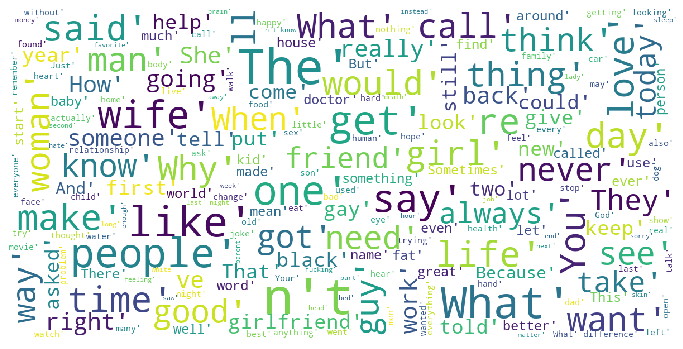

In [27]:
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(corpus)

## Text Sentiment - polarity

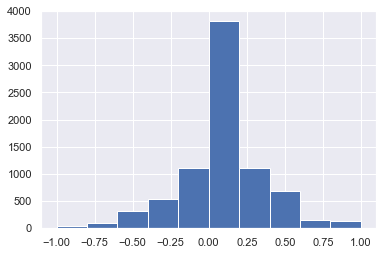

In [28]:
def polarity(text):
    return TextBlob(text).sentiment.polarity
data['polarity_score'] = data['text'].apply(lambda x : polarity(x))
data['polarity_score'].hist()

<BarContainer object of 3 artists>

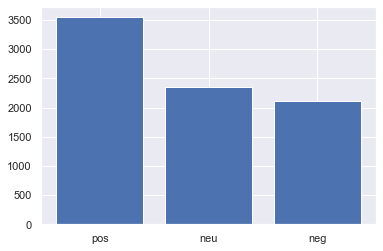

In [29]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
data['polarity'] = data['polarity_score'].map(lambda x: sentiment(x))
plt.bar(data.polarity.value_counts().index,data.polarity.value_counts())

In [30]:
data[data['polarity']=='pos']['text'].head()

0    TENNESSEE: We're the best state. Nobody even c...
1    A man inserted an advertisement in the classif...
2    How many men does it take to open a can of bee...
6    I enrolled on some skill training and extra cu...
7    ME: I'm such an original. Truly one of a kind....
Name: text, dtype: object

In [31]:
data[data['polarity']=='neg']['text'].head()

4     Roses are dead. Love is fake. Weddings are bas...
9     I got REALLY angry today and it wasn't about n...
10    A dog in Mexico named Frida saved the lives of...
12    Stop calling 9-1-1 because you've run out of t...
13    When you march the streets shouting with peopl...
Name: text, dtype: object

In [32]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\keerr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<BarContainer object of 3 artists>

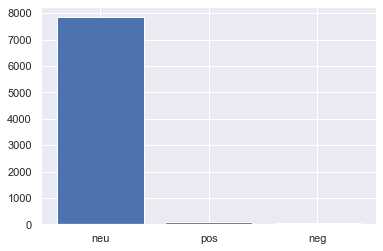

In [33]:
sid = SentimentIntensityAnalyzer()
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])
data['polarity'] = data['text'].map(lambda x: get_vader_score(x))
polarity = data['polarity'].replace({0:'neg',1:'neu',2:'pos'})
plt.bar(polarity.value_counts().index,polarity.value_counts())